# Model Evaluation Notebook

This notebook evaluates the performance of the trained transformer model against baseline methods.

## Setup and Data Loading

In [7]:
import sys

sys.path.append("..")

from core.DataLoader import DataPreprocessor, get_load_config_from_yaml
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.assignment_models as Models
import core
import os

# Configuration
if False:
    PLOTS_DIR = "plots/ToponiumInfusedTransformer/"
    MODEL_DIR = "models/mixed_model"
else:
    PLOTS_DIR = "plots/Transformer_HLF/"
    MODEL_DIR = "../models/FeatureConcatTransformer_HLF_d256_l4_h8"


CONFIG_PATH = "../config/workspace_config_HLF.yaml"

# Create directories
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Set plotting style
plt.rcParams.update({"font.size": 16})

# Load data
load_config = get_load_config_from_yaml(CONFIG_PATH)
DataProcessor = DataPreprocessor(load_config)

with open(CONFIG_PATH, "r") as file:
    data_configs = yaml.safe_load(file)

data_config = DataProcessor.load_from_npz(
    data_configs["data_path"]["nominal"], max_events=2_000_000
)
X_val, y_val = DataProcessor.get_data()
del DataProcessor

## Load Model and Setup Evaluator

In [8]:
reload(Models)
reload(core)
TransformerMatcher = Models.FeatureConcatTransformer(data_config, name=r"Transformer")

FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.


In [9]:

TransformerMatcher.load_model(f"{MODEL_DIR}/model.keras")

Model loaded from ../models/FeatureConcatTransformer_HLF_d256_l4_h8/model.keras
Training history loaded from ../models/FeatureConcatTransformer_HLF_d256_l4_h8/model_history.npz


In [10]:
import core.reconstruction.BaselineMethods as BaselineMethods
import core.evaluation as Evaluation
from core.reconstruction import GroundTruthReconstructor

reload(Evaluation)
reload(BaselineMethods)
delta_r_assigner = BaselineMethods.DeltaRAssigner(
    data_config,
    use_nu_flows=True,
)
chi_square = BaselineMethods.ChiSquareAssigner(
    data_config,
    use_nu_flows=True,
    use_nu_flows_for_assignment=True,
    top_mass=173.5e3,
)
ground_truth_assigner = GroundTruthReconstructor(data_config, use_nu_flows=True)
evaluator = Evaluation.ReconstructionEvaluator(
    [
        delta_r_assigner,
        chi_square,
        TransformerMatcher,
        ground_truth_assigner,
    ],
    X_val,
    y_val,
)

2025-12-15 16:54:47.827813: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-12-15 16:55:40.176513: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert


In [ ]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_quotient_ttbar_mass.pdf")

In [ ]:
evaluator.save_accuracy_latex_table(n_bootstrap=100, confidence=0.95, save_dir=PLOTS_DIR)

In [ ]:
fig, ax = evaluator.plot_binned_c_hel_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_hel_resolution_comparison.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_c_han_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_han_resolution_comparison.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")

## Accuracy Plots

In [ ]:
fig, ax = evaluator.plot_all_accuracies(n_bootstrap=10)
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")

In [ ]:
fig, ax = evaluator.plot_all_selection_accuracies(n_bootstrap=10)
fig.savefig(PLOTS_DIR + "all_selection_accuracies.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_config.max_jets + 1),
    bins=data_config.max_jets - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(2, data_config.max_jets + 1)])
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_config.max_jets + 1),
    bins=data_config.max_jets - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(2, data_config.max_jets + 1)])
ax.set_xlim(2, data_config.max_jets + 1)
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_accuracy_quotients_N_jets.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_quotient_ttbar_pT.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="dR_l1l2",
    fancy_feature_label=r"$\Delta R(\ell_1,\ell_2)$",
    xlims=(0, 5),
    bins=10,
    n_bootstrap=10,
)
ax.set_xlim(0, 5)
fig.savefig(PLOTS_DIR + "binned_accuracy_dR_l1l2.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_ttbar_mass.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(3, data_config.max_jets + 1),
    bins=data_config.max_jets - 2,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(3, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(3, data_config.max_jets + 1)])
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_N_jets.pdf")

## Distribution Plots

In [ ]:
fig, ax = evaluator.plot_ttbar_mass_deviation_distribution(bins=20, xlims=(-0.5, 3))
ax.set_yscale("log")
ax.set_xlabel(
    r"$\frac{m_{t\bar{t}}^{\text{reco}}-m_{t\bar{t}}^{\text{truth after FSR}}}{m_{t\bar{t}}^{\text{truth after FSR}}}$"
)
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_deviation_distribution.pdf", bbox_inches="tight")

In [ ]:
fig, ax = evaluator.plot_c_han_deviation_distribution(bins=20, xlims=(-1, 1))
ax.set_yscale("log")
ax.set_xlabel(
    r"$c_{han}(\text{truth}) - c_{han}(\text{reco}) $"
)
fig.savefig(f"{PLOTS_DIR}/ttbar_c_han_deviation_distribution.pdf", bbox_inches="tight")

In [ ]:
fig, ax = evaluator.plot_c_hel_deviation_distribution(bins=20, xlims=(-1, 1))
ax.set_yscale("log")
ax.set_xlabel(
    r"$c_{hel}(\text{truth}) - c_{hel}(\text{reco})$"
)
fig.savefig(f"{PLOTS_DIR}/ttbar_c_hel_deviation_distribution.pdf", bbox_inches="tight")

In [ ]:
fig, axes = evaluator.plot_c_hel_distributions(bins=20, save_individual_plots=True)
for index, figure in enumerate(fig):
    figure.savefig(f"{PLOTS_DIR}/c_hel_distributions_{index}.pdf", bbox_inches="tight")

In [ ]:
fig, axes = evaluator.plot_c_han_distributions(bins=20, save_individual_plots=True)
for index, figure in enumerate(fig):
    figure.savefig(f"{PLOTS_DIR}/c_han_distributions_{index}.pdf", bbox_inches="tight")

## Resolution Plots

## Mass Resolution and Deviation Plots

In [ ]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=10,
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_top_mass_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=10,
    bins=10,
)
ticks = ax.get_xticks()
ax.axhline(0, color="black", linestyle="--")
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_deviation_comparison.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_ttbar_mass_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "ttbar_mass_deviation_comparison.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_c_hel_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_han_deviation_comparison.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_c_han_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_han_deviation_comparison.pdf")

## Confusion Matrices and Complementarity

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")


Computing binned accuracy for truth_initial_parton_num_gluons...


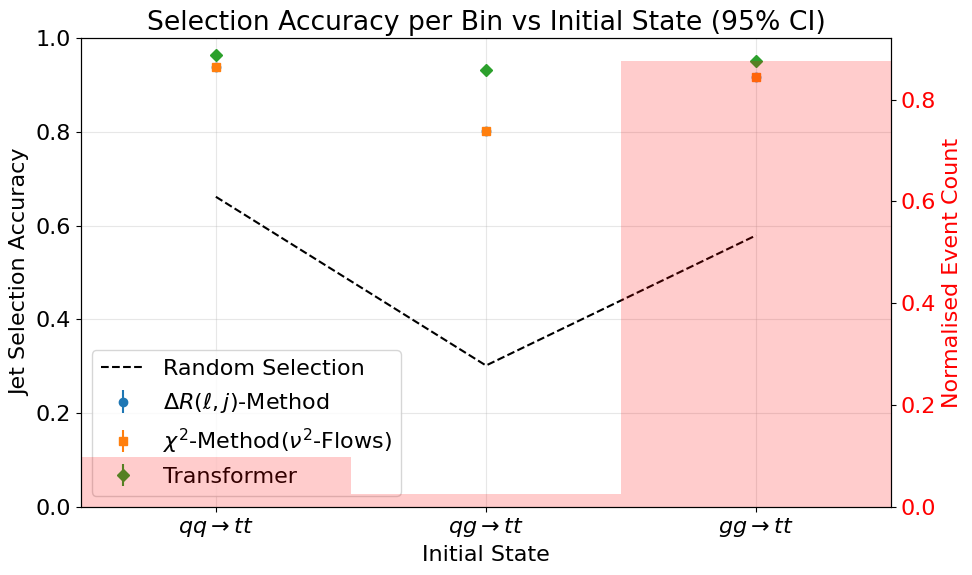

In [11]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_initial_state.pdf")


Computing binned accuracy quotients for truth_initial_parton_num_gluons...


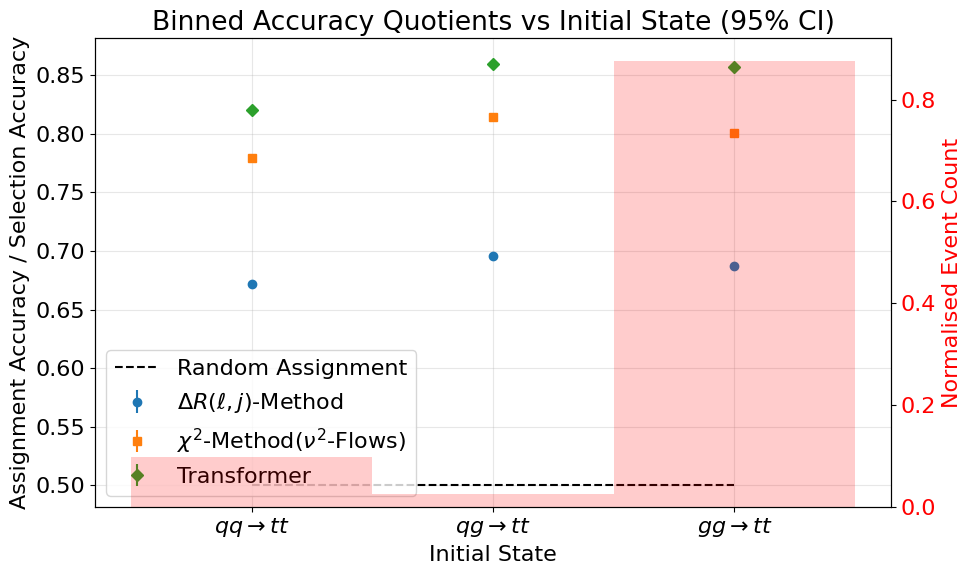

In [12]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_quotients_initial_state.pdf")

In [ ]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

In [ ]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(10.5, 10))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")